In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from time import time
import itertools
from matplotlib.ticker import NullFormatter
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.cm as cm
import seaborn as sn

from sportsreference.nba.boxscore import Boxscore
from sportsreference.nba.roster import Roster, Player
from sportsreference.nba.schedule import Schedule
from sportsreference.nba.teams import Teams

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
df_career = pd.read_csv('data/2nba_player_stats_by_career.csv')

In [9]:
df_career.head()

,id,and_ones,assist_percentage,assists,block_percentage,blocking_fouls,blocks,box_plus_minus,center_percentage,defensive_box_plus_minus,...,age,avg_salary,years_played,year_list,current_player,contract_total,contract_length,current_salary,current_avg_salary,current_team
0,bareajo01 Career,NaN,33.2,3270.0,0.1,NaN,24.0,-0.7,0,-1.4,...,NaN,2.795708e+06,14,"['2006-07', '2007-08', '2008-09', '2009-10', '...",False,NaN,NaN,NaN,NaN,NaN
1,broekry01 Career,NaN,7.5,33.0,1.1,NaN,8.0,-0.5,0,-0.3,...,NaN,1.127658e+06,2,"['2018-19', '2019-20']",False,NaN,NaN,NaN,NaN,NaN
2,brunsja01 Career,NaN,23.2,555.0,0.2,NaN,8.0,-1.0,0,-0.8,...,NaN,8.822840e+05,3,"['2018-19', '2019-20', '2020-21']",True,3465918.0,2.0,1663861.0,1732959.0,DAL
3,burketr01 Career,NaN,25.0,1447.0,0.4,NaN,48.0,-1.1,0,-1.6,...,NaN,1.983643e+06,8,"['2013-14', '2014-15', '2015-16', '2016-17', '...",True,9999999.0,3.0,3174603.0,3333333.0,DAL
4,caulewi01 Career,NaN,10.1,579.0,3.2,NaN,317.0,0.0,0,0.6,...,NaN,2.921326e+06,6,"['2015-16', '2016-17', '2017-18', '2018-19', '...",True,8200000.0,2.0,4000000.0,4100000.0,DAL


## Dropping columns with all null or useless values

In [12]:
# Function that finds columns in which values have less than 20 unique values are taken in and removed

def remove_career_cols(df_career):
    drop_lst = []
    for col in df_career.columns:
        unique = df_career[col].unique()
        val = len(unique)
        if val < 20:
            drop_lst.append(str(col))
            print(f'{col}: has {val} values')
            print(f'Values include:')
            print(f'     {unique}')

    print(f'Drop List: {drop_lst}')
    return df_career.drop(drop_lst, axis=1)

In [13]:
new_df = remove_career_cols(df_career)
new_df

and_ones: has 1 values
Values include:
     [nan]
blocking_fouls: has 1 values
Values include:
     [nan]
center_percentage: has 1 values
Values include:
     [0]
dunks: has 1 values
Values include:
     [nan]
half_court_heaves_made: has 7 values
Values include:
     [0. 1. 2. 3. 6. 4. 5.]
lost_ball_turnovers: has 1 values
Values include:
     [nan]
net_plus_minus: has 1 values
Values include:
     [nan]
offensive_fouls: has 1 values
Values include:
     [nan]
on_court_plus_minus: has 1 values
Values include:
     [nan]
other_turnovers: has 1 values
Values include:
     [nan]
passing_turnovers: has 1 values
Values include:
     [nan]
percentage_field_goals_as_dunks: has 1 values
Values include:
     [nan]
percentage_of_three_pointers_from_corner: has 1 values
Values include:
     [nan]
percentage_shots_three_pointers: has 1 values
Values include:
     [nan]
percentage_shots_two_pointers: has 1 values
Values include:
     [nan]
point_guard_percentage: has 1 values
Values include:
     [

,id,assist_percentage,assists,block_percentage,blocks,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,...,win_shares_per_48_minutes,birth_date,name,avg_salary,years_played,year_list,contract_total,current_salary,current_avg_salary,current_team
0,bareajo01 Career,33.2,3270.0,0.1,24.0,-0.7,-1.4,10.4,1495.0,10.1,...,0.070,1984-06-26,J.J. Barea,2.795708e+06,14,"['2006-07', '2007-08', '2008-09', '2009-10', '...",NaN,NaN,NaN,NaN
1,broekry01 Career,7.5,33.0,1.1,8.0,-0.5,-0.3,15.5,93.0,0.5,...,0.093,1990-08-23,Ryan Broekhoff,1.127658e+06,2,"['2018-19', '2019-20']",NaN,NaN,NaN,NaN
2,brunsja01 Career,23.2,555.0,0.2,8.0,-1.0,-0.8,11.2,386.0,2.2,...,0.099,1996-08-31,Jalen Brunson,8.822840e+05,3,"['2018-19', '2019-20', '2020-21']",3465918.0,1663861.0,1732959.0,DAL
3,burketr01 Career,25.0,1447.0,0.4,48.0,-1.1,-1.6,8.0,678.0,4.6,...,0.063,1992-11-12,Trey Burke,1.983643e+06,8,"['2013-14', '2014-15', '2015-16', '2016-17', '...",9999999.0,3174603.0,3333333.0,DAL
4,caulewi01 Career,10.1,579.0,3.2,317.0,0.0,0.6,21.3,1689.0,10.1,...,0.121,1993-08-18,Willie Cauley-Stein,2.921326e+06,6,"['2015-16', '2016-17', '2017-18', '2018-19', '...",8200000.0,4000000.0,4100000.0,DAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,murdoer01 Career,34.3,2467.0,0.4,69.0,2.0,0.9,9.2,922.0,11.9,...,0.103,1968-06-14,Eric Murdock,1.114725e+06,10,"['1991-92', '1992-93', '1993-94', '1994-95', '...",NaN,NaN,NaN,NaN
2036,anstech01 Career,11.0,127.0,2.2,65.0,-2.9,0.2,19.2,356.0,2.6,...,0.062,1975-01-01,Chris Anstey,9.376067e+05,3,"['1997-98', '1998-99', '1999-00']",NaN,NaN,NaN,NaN
2037,armstbj01 Career,20.9,2479.0,0.2,47.0,-0.2,-0.6,7.4,1129.0,13.4,...,0.121,1967-09-09,B.J. Armstrong,1.489091e+06,11,"['1989-90', '1990-91', '1991-92', '1992-93', '...",NaN,NaN,NaN,NaN
2038,reevekh01 Career,24.3,886.0,0.4,32.0,-1.3,-0.5,8.3,417.0,3.4,...,0.069,1972-07-15,Khalid Reeves,1.502218e+06,6,"['1994-95', '1995-96', '1996-97', '1997-98', '...",NaN,NaN,NaN,NaN


In [5]:
nulls = ['and_ones', 'blocking_fouls', 'dunks', 'lost_ball_turnovers',
'net_plus_minus', 'offensive_fouls', 'on_court_plus_minus',
'other_turnovers', 'passing_turnovers', 'percentage_field_goals_as_dunks',
'percentage_of_three_pointers_from_corner', 'percentage_shots_three_pointers',
'percentage_shots_two_pointers', 'points_generated_by_assists',
'shooting_fouls', 'shooting_fouls_drawn', 'shots_blocked',
'take_fouls', 'team_abbreviation', 'three_point_shot_percentage_from_corner',
'three_pointers_assisted_percentage', 'two_pointers_assisted_percentage',
'age', 'center_percentage', 'point_guard_percentage',
'power_forward_percentage', 'shooting_guard_percentage',
'small_forward_percentage', 'year', 'player_id']

In [6]:
df_career = df_career.drop(['and_ones', 'blocking_fouls', 'dunks', 'lost_ball_turnovers',
'net_plus_minus', 'offensive_fouls', 'on_court_plus_minus',
'other_turnovers', 'passing_turnovers', 'percentage_field_goals_as_dunks',
'percentage_of_three_pointers_from_corner', 'percentage_shots_three_pointers',
'percentage_shots_two_pointers', 'points_generated_by_assists',
'shooting_fouls', 'shooting_fouls_drawn', 'shots_blocked',
'take_fouls', 'team_abbreviation', 'three_point_shot_percentage_from_corner',
'three_pointers_assisted_percentage', 'two_pointers_assisted_percentage',
'age', 'center_percentage', 'point_guard_percentage',
'power_forward_percentage', 'shooting_guard_percentage',
'small_forward_percentage', 'year', 'player_id'], axis=1)

## Dropping Rows(players)

In [7]:
# Removing non-Salaried Players

def clean_salaries(df_career):
    # Dropping players that don't have any recorded salary
    df_career = df_career.dropna(subset=['salary'])
    # And players whos salary appeared as $0.0 for some reason
    df_career = df_career[df_career['salary'] > 0]
    return df_career

In [8]:
# Double-checking that the double_names are actually unique players (Spoiler Alert: they are)
#double_names = ['Dee Brown', 'Marcus Williams', 'Chris Johnson', 'Mike James']
#df_career[df_career['name'].isin(double_names)]
name_counts = df_career.groupby('name')['name'].count()
name_counts.sort_values(ascending=False)

name
Dee Brown            2
Marcus Williams      2
Chris Johnson        2
Mike James           2
Fred Vinson          1
                    ..
Michael Dickerson    1
Michael Doleac       1
Michael Finley       1
Michael Frazier      1
A.C. Green           1
Name: name, Length: 1919, dtype: int64

In [9]:
# Setting index to the Players name & modifying the ID's so that they don't have 'Career appended for some reason'
df_career['id'] = df_career['id'].str.split(' ').str[0]
df_career = df_career.set_index('name')

In [10]:
def to_inches(height):
    feet, inches = str(height).split('-')
    return (int(feet)*12) + int(inches)

In [11]:
df_career['height'] = df_career['height'].apply(to_inches)

In [12]:
df_career['height']

name
J.J. Barea             70
Ryan Broekhoff         78
Jalen Brunson          73
Trey Burke             72
Willie Cauley-Stein    84
                       ..
Eric Murdock           73
Chris Anstey           84
B.J. Armstrong         74
Khalid Reeves          75
Dedric Willoughby      75
Name: height, Length: 1923, dtype: int64

In [13]:
player_ids = df_career['id'].values
player_ids

array(['bareajo01', 'broekry01', 'brunsja01', ..., 'armstbj01',
       'reevekh01', 'willode01'], dtype=object)

In [14]:
player_names = df_career.index.values
player_names

array(['J.J. Barea', 'Ryan Broekhoff', 'Jalen Brunson', ...,
       'B.J. Armstrong', 'Khalid Reeves', 'Dedric Willoughby'],
      dtype=object)

## Filling NaNs

In [15]:
# Grabbing players that are not currently assigned positions
unpositioned_players = df_career[df_career['position'].isna()]
#unpositioned_players

In [16]:
# Filling nan for position with 'na' & then the rest of the categories with 0's
# because they're only nan's since they haven't attempted
df_career['position'] = df_career['position'].fillna('na')

In [17]:
# Creating current/past players DF's & then dropping the columns that only pertain to current players from career_df
def current_and_past(df_career):
    df_past_players = df_career[df_career['current_player'] == False]
    #df_past_players
    df_current_players = df_career[df_career['current_player'] == True]
    #df_current_players
    current_player_features = ['contract_total', 'contract_length', 'current_salary', 'current_avg_salary', 'current_team']
    df_past_players = df_past_players.drop(current_player_features, axis=1)
    return df_past_players, df_current_players

In [18]:
df_career = df_career.fillna(0)

In [19]:
# Creating seperate DFs for different use cases
df_career_no_salaries = df_career.drop(['salary'], axis=1)

non_stats = ['nationality', 'position', 'birth_date', 'year_list', 'id']

df_pure_stats = df_career.drop(non_stats, axis=1)
df_pure_stats_no_salary = df_pure_stats.drop(['salary'], axis=1)

In [20]:
df_pure_stats['current_player'] = df_pure_stats['current_player'].astype(int)

In [21]:
# Creating DF that only contains stats that are already averaged
def just_avgs(df):
    df_avgs = df[['assist_percentage', 'avg_salary', 'block_percentage', 'box_plus_minus',
    'defensive_box_plus_minus', 'defensive_rebound_percentage', 'effective_field_goal_percentage',
    'field_goal_percentage', 'field_goal_perc_sixteen_foot_plus_two_pointers',
    'field_goal_perc_ten_to_sixteen_feet', 'field_goal_perc_three_to_ten_feet',
    'field_goal_perc_zero_to_three_feet', 'field_goal_percentage',
    'free_throw_attempt_rate', 'free_throw_percentage', 'offensive_box_plus_minus',
    'offensive_rebound_percentage', 'player_efficiency_rating',
    'three_point_percentage', 'total_rebound_percentage', 'true_shooting_percentage',
    'turnover_percentage', 'two_point_percentage', 'usage_percentage',
    'win_shares', 'win_shares_per_48_minutes', 'years_played']]
    return df_avgs

In [22]:
df_totals = df_pure_stats.drop(avgs, axis=1)

## Sanity check before modeling

In [23]:
df_pure_stats.columns

Index(['assist_percentage', 'assists', 'block_percentage', 'blocks',
       'box_plus_minus', 'defensive_box_plus_minus',
       'defensive_rebound_percentage', 'defensive_rebounds',
       'defensive_win_shares', 'effective_field_goal_percentage',
       'field_goal_attempts', 'field_goal_perc_sixteen_foot_plus_two_pointers',
       'field_goal_perc_ten_to_sixteen_feet',
       'field_goal_perc_three_to_ten_feet',
       'field_goal_perc_zero_to_three_feet', 'field_goal_percentage',
       'field_goals', 'free_throw_attempt_rate', 'free_throw_attempts',
       'free_throw_percentage', 'free_throws', 'games_played', 'games_started',
       'half_court_heaves', 'half_court_heaves_made', 'height',
       'minutes_played', 'offensive_box_plus_minus',
       'offensive_rebound_percentage', 'offensive_rebounds',
       'offensive_win_shares', 'percentage_sixteen_foot_plus_two_pointers',
       'percentage_ten_to_sixteen_footers', 'percentage_three_to_ten_footers',
       'percentage_zero_to

In [25]:
df_totals.head()

,assists,blocks,defensive_rebounds,defensive_win_shares,field_goal_attempts,field_goals,free_throw_attempts,free_throws,games_played,games_started,...,three_point_attempt_rate,three_point_attempts,three_pointers,total_rebounds,turnovers,two_point_attempts,two_pointers,value_over_replacement_player,weight,current_player
name,,,,,,,,,,,,,,,,,,,,,
J.J. Barea,3270.0,24.0,1495.0,10.1,6685.0,2832.0,1174.0,932.0,831.0,107.0,...,0.349,2330.0,819.0,1748.0,1264.0,4355.0,2013.0,5.3,180,0
Ryan Broekhoff,33.0,8.0,93.0,0.5,185.0,79.0,27.0,22.0,59.0,1.0,...,0.778,144.0,58.0,106.0,22.0,41.0,21.0,0.2,215,0
Jalen Brunson,555.0,8.0,386.0,2.2,1314.0,636.0,297.0,229.0,171.0,64.0,...,0.324,426.0,155.0,446.0,210.0,888.0,481.0,0.9,190,1
Trey Burke,1447.0,48.0,678.0,4.6,4181.0,1724.0,617.0,496.0,438.0,129.0,...,0.362,1514.0,526.0,833.0,520.0,2667.0,1198.0,2.1,185,1
Willie Cauley-Stein,579.0,317.0,1689.0,10.1,2763.0,1500.0,893.0,548.0,384.0,249.0,...,0.010,27.0,5.0,2344.0,364.0,2736.0,1495.0,4.4,240,1


In [26]:
df_avgs.astype('float64')

,assist_percentage,avg_salary,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,effective_field_goal_percentage,field_goal_percentage,field_goal_perc_sixteen_foot_plus_two_pointers,field_goal_perc_ten_to_sixteen_feet,...,player_efficiency_rating,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares,win_shares_per_48_minutes,years_played
name,,,,,,,,,,,,,,,,,,,,,
J.J. Barea,33.2,2.795708e+06,0.1,-0.7,-1.4,10.4,0.485,0.424,0.398,0.417,...,14.5,0.352,6.0,0.515,14.9,0.462,23.4,23.8,0.070,14.0
Ryan Broekhoff,7.5,1.127658e+06,1.1,-0.5,-0.3,15.5,0.584,0.427,1.000,0.143,...,11.4,0.403,8.9,0.604,10.1,0.512,14.8,1.2,0.093,2.0
Jalen Brunson,23.2,8.822840e+05,0.2,-1.0,-0.8,11.2,0.543,0.484,0.443,0.495,...,14.5,0.364,6.6,0.573,12.7,0.542,19.7,7.5,0.099,3.0
Trey Burke,25.0,1.983643e+06,0.4,-1.1,-1.6,8.0,0.475,0.412,0.435,0.429,...,14.0,0.347,4.9,0.502,10.5,0.449,23.0,12.7,0.063,8.0
Willie Cauley-Stein,10.1,2.921326e+06,3.2,0.0,0.6,21.3,0.544,0.543,0.368,0.336,...,16.8,0.185,14.5,0.563,10.3,0.546,17.4,22.2,0.121,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eric Murdock,34.3,1.114725e+06,0.4,2.0,0.9,9.2,0.473,0.438,0.373,0.405,...,17.4,0.343,6.2,0.523,16.8,0.462,21.9,25.6,0.103,10.0
Chris Anstey,11.0,9.376067e+05,2.2,-2.9,0.2,19.2,0.416,0.413,0.363,0.250,...,13.2,0.138,14.2,0.477,14.7,0.424,21.2,2.8,0.062,3.0
B.J. Armstrong,20.9,1.489091e+06,0.2,-0.2,-0.6,7.4,0.513,0.477,0.495,0.373,...,14.5,0.425,4.3,0.555,11.9,0.487,18.4,45.0,0.121,11.0


In [62]:
df_avgs.sort_values(by=['avg_salary'], ascending=False)

,assist_percentage,avg_salary,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,effective_field_goal_percentage,field_goal_percentage,field_goal_perc_sixteen_foot_plus_two_pointers,field_goal_perc_ten_to_sixteen_feet,...,player_efficiency_rating,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares,win_shares_per_48_minutes,years_played
name,,,,,,,,,,,,,,,,,,,,,
LeBron James,36.6,1.722842e+07,1.6,8.9,1.8,18.6,0.543,0.504,0.385,0.368,...,27.4,0.345,11.3,0.587,13.2,0.550,31.5,242.1,0.233,18
Kobe Bryant,24.2,1.641190e+07,1.0,4.6,-0.1,12.7,0.482,0.447,0.402,0.430,...,22.9,0.329,8.1,0.550,11.6,0.479,31.8,172.7,0.170,20
Kevin Durant,19.6,1.624343e+07,2.3,6.7,0.7,18.5,0.543,0.493,0.440,0.459,...,25.2,0.382,10.8,0.614,12.4,0.533,30.2,144.4,0.217,14
Chris Paul,45.3,1.619682e+07,0.3,7.4,2.2,12.8,0.520,0.471,0.466,0.480,...,24.9,0.369,7.5,0.582,13.3,0.508,23.9,185.8,0.241,16
Blake Griffin,22.2,1.604293e+07,1.2,3.6,0.2,21.6,0.517,0.496,0.376,0.317,...,21.6,0.332,14.3,0.560,11.8,0.520,27.8,75.9,0.163,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Marcus Williams,13.6,6.445000e+03,1.9,-5.4,-2.0,23.8,0.318,0.318,0.300,0.600,...,10.4,0.000,17.8,0.318,0.0,0.318,26.2,-0.1,-0.084,2
Aaron Jackson,4.0,4.608000e+03,0.0,-8.9,-2.3,3.2,0.389,0.333,0.000,0.000,...,2.4,0.250,4.8,0.405,9.2,0.400,13.7,0.0,-0.017,1
Kirk Penney,10.4,4.475000e+03,0.0,-15.1,-4.0,7.8,0.278,0.222,0.200,0.000,...,-6.0,0.250,3.9,0.278,35.7,0.200,21.8,-0.2,-0.306,2


In [25]:
range(2,16)

range(2, 16)

# Exploratory Graphs

In [39]:
df_career['salary'].sort_values(ascending=False)

name
Kevin Garnett       343872398.0
Kobe Bryant         328238062.0
LeBron James        310111480.0
Shaquille O'Neal    292198327.0
Carmelo Anthony     262088584.0
                       ...     
Marcus Williams         12890.0
John Holland             9266.0
Kirk Penney              8950.0
Andy Panko               5000.0
Aaron Jackson            4608.0
Name: salary, Length: 1923, dtype: float64

In [41]:
def mil_format(x):
    return "${:.1f}M".format(x/1000000)

In [47]:
avg_sal = df_avgs['avg_salary'].sort_values(ascending=False)
avg_sal = avg_sal.apply(mil_format)[:50]

In [52]:
top_50 = avg_sal[:50].sort_values(ascending=False)

In [53]:
top_50

name
LeBron James         $17.2M
Kobe Bryant          $16.4M
Kevin Durant         $16.2M
Chris Paul           $16.2M
Blake Griffin        $16.0M
Russell Westbrook    $15.9M
Kevin Garnett        $15.6M
James Harden         $15.5M
Shaquille O'Neal     $15.4M
Chris Bosh           $15.1M
Carmelo Anthony      $14.6M
Dwight Howard        $14.3M
Chandler Parsons     $14.1M
Stephen Curry        $14.1M
Marc Gasol           $13.9M
Gordon Hayward       $13.7M
Damian Lillard       $13.6M
Anthony Davis        $13.5M
Kevin Love           $13.5M
Al Horford           $13.5M
John Wall            $13.4M
Paul George          $13.2M
LaMarcus Aldridge    $13.1M
Bradley Beal         $13.0M
Kyrie Irving         $12.6M
Gilbert Arenas       $12.6M
Mike Conley          $12.5M
Dwyane Wade          $12.4M
DeMar DeRozan        $12.4M
Klay Thompson        $12.4M
Joe Johnson          $12.2M
Paul Millsap         $12.2M
Otto Porter          $12.2M
Dirk Nowitzki        $12.2M
Andre Drummond       $12.1M
Amar'e Stoudemi

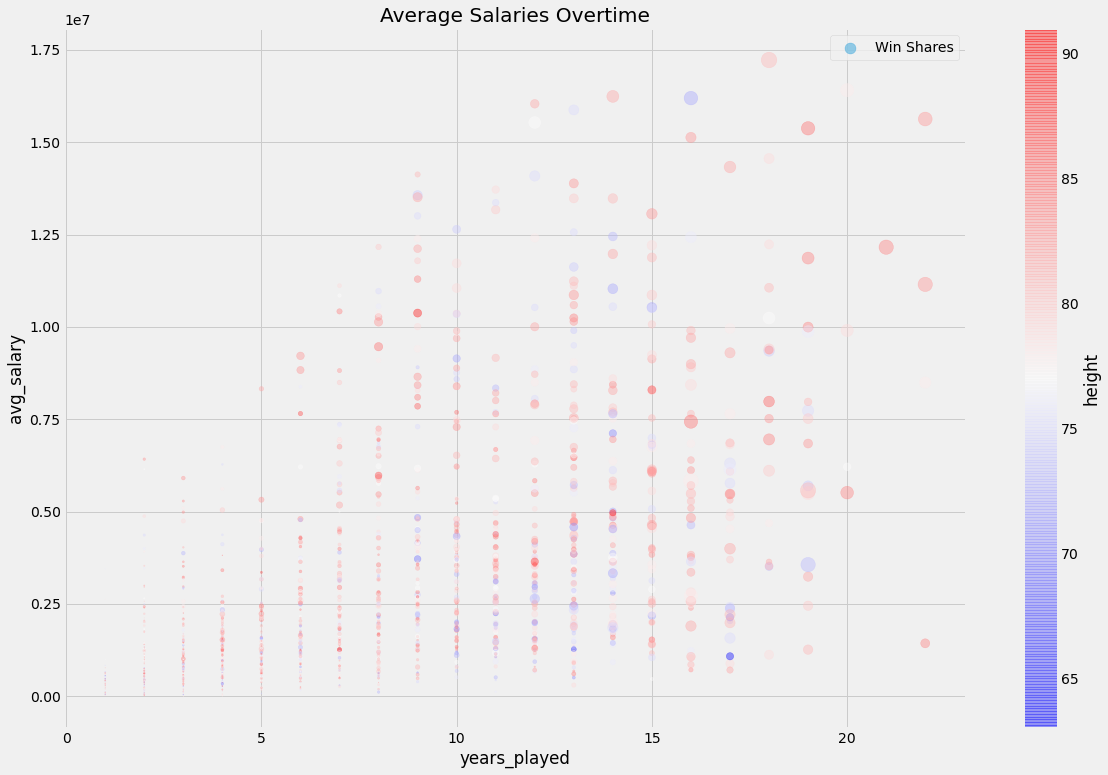

In [36]:
df_career.plot(kind="scatter", x="years_played", y="avg_salary", alpha=0.4,
             s='win_shares', label="Win Shares", figsize=(18,12),
             c="height", cmap=plt.get_cmap("bwr"), colorbar=True,
             title='Average Salaries Overtime')
plt.legend()
#plt.savefig('images/avg_salaries_by_years_played')

# Modeling Section

In [26]:
def find_best_cluster_amount(x, comps, loops):
    d = {}
    for i in range(loops):
        # Fits data to a new array using PCA given the number of components passed through comp parameter
        after_pca = PCA(n_components=comps,whiten=True).fit_transform(x)
        
        k_range = range(2,16) # Range of amount of clusters I might expect to see
        
        # Doing KMeans clustering on the range chosen in k_range
        k_means_var = [KMeans(n_clusters=k).fit(after_pca) for k in k_range]
        
        # Capturing labels for KMeans_var
        labels = [i.labels_ for i in k_means_var]
        
        # Calculating silhouette score at each label
        sil_score = [silhouette_score(after_pca, i, metric='euclidean') for i in labels]
        
        # Generates list of points where center of clusters are
        centroids = [i.cluster_centers_ for i in k_means_var]
        
        # Calculates distance between newly generated data and the centroids found in KMeans
        k_euclid = [cdist(after_pca,cent,'euclidean') for cent in centroids]
        
        dist = [np.min(ke, axis=1) for ke in k_euclid]
        wcss = [sum(d**2) for d in dist]
        tss = sum(pdist(after_pca)**2/after_pca.shape[0])
        bss = tss - wcss
        
        sil_arr = np.transpose(sil_score)*100
        max_score = np.max(sil_arr)
        max_score_index = np.argmax(sil_arr == max_score)
        
        if max_score_index in d:
            d[max_score_index] += 1
        else:
            d[max_score_index] = 1
    
    return d

In [27]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [28]:
# Silhouette Graphing:

""" 
    X = x
    range_n_clusters = range(2,10)
 """

def silhouette_graph(X, range_n_clusters):
    # taken from sklearn
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            cmap = cm.get_cmap('Spectral')
            color = cmap(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed

        colors = cmap(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

        plt.show()

## Normalizing with MinMaxScalar

In [29]:
x = df_avgs.values
x.shape

(1923, 27)

In [30]:
x = df_avgs.values
min_max_scalar = MinMaxScaler()
x_scaled = min_max_scalar.fit_transform(x)
df_avgs_normalized = pd.DataFrame(x_scaled)

In [31]:
x = df_avgs_normalized.values
x.shape[1]

27

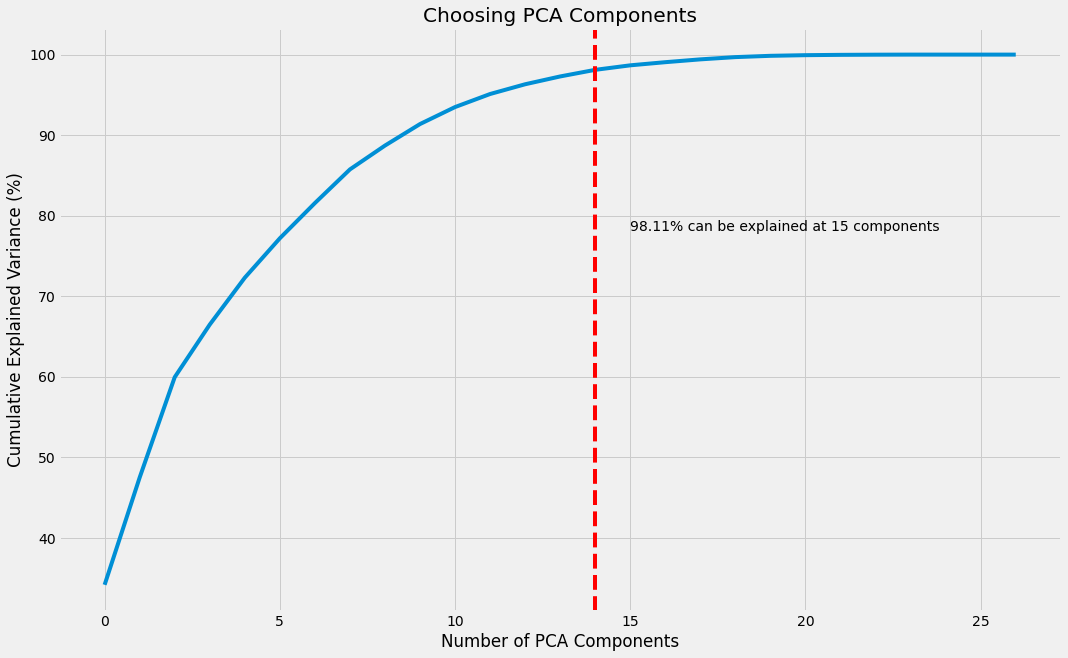

In [32]:
pca = PCA(x.shape[1])
pca.fit(x)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var_to_beat = np.argwhere(var1 >= 98)
var_explained = np.round(var1[var_to_beat[0]], decimals=2)[0]
comps = var_to_beat.flatten()[1]

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(var1)
ax.set_title('Choosing PCA Components')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Cumulative Explained Variance (%)')
ax.axvline(var_to_beat[0], c='r', linestyle='--')
ax.annotate(f'{var_explained}% can be explained at {comps} components', xy=(comps, var_explained-20))

plt.savefig('images/pca_scree_minmax.png')

In [33]:
d_clusters = find_best_cluster_amount(x, comps, 250)
d_clusters = dict(sorted(d_clusters.items(), key=lambda item: item[1], reverse=True))
print(d_clusters)
print(f'Number of Clusters in order from best to worst: {d_clusters.keys()}')

{1: 56, 13: 46, 12: 38, 2: 32, 0: 31, 6: 11, 11: 8, 7: 7, 8: 7, 5: 6, 10: 4, 9: 3, 4: 1}
Number of Clusters in order from best to worst: dict_keys([1, 13, 12, 2, 0, 6, 11, 7, 8, 5, 10, 9, 4])


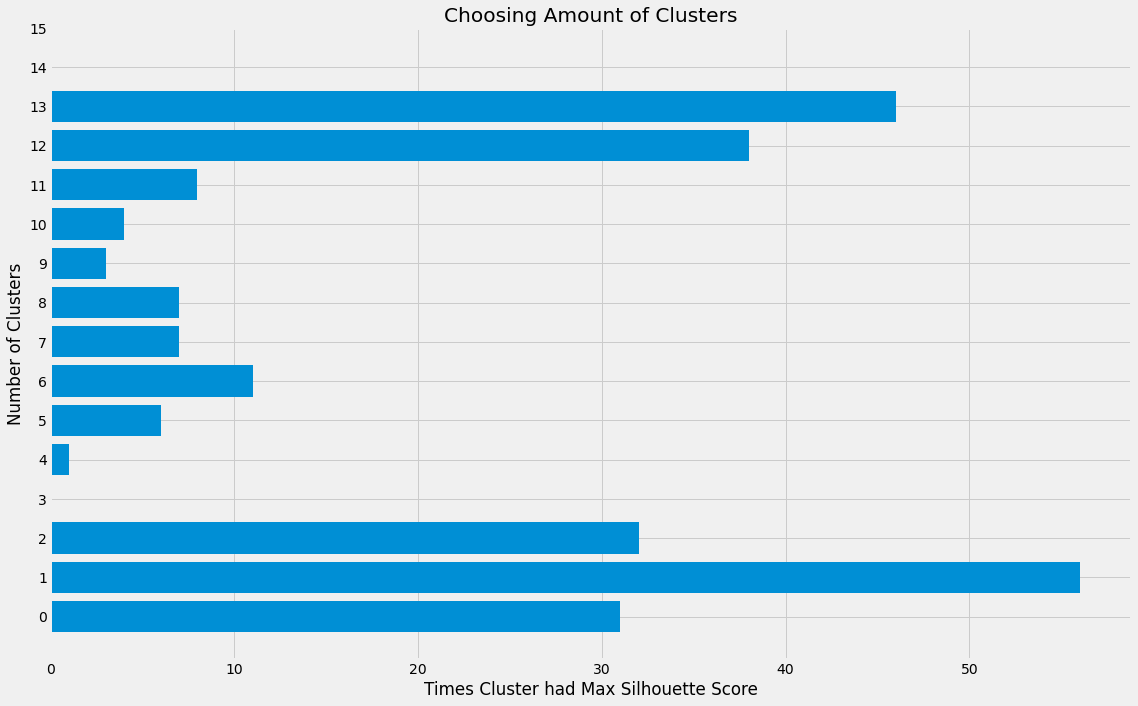

In [34]:
# Plotting Clusters
fig, ax = plt.subplots(figsize=(16,10))

ax.barh(list(d_clusters.keys()), list(d_clusters.values()))
ax.set_title('Choosing Amount of Clusters')
ax.set_xlabel('Times Cluster had Max Silhouette Score')
ax.set_ylabel('Number of Clusters')
ax.set_yticks(np.arange(16))

fig = ax.figure
fig.set_size_inches(16,10)
fig.tight_layout(pad=1)
fig.savefig('images/number_of_clusters_minmax.png')

## Normalizing with Standard Scalar

In [35]:
x = df_avgs.values
x.shape

(1923, 27)

In [50]:
km = KMeans(5)
y = km.fit_predict(x)

In [68]:
x = df_totals.values # df_total
standard_scalar = RobustScaler()
x_scaled = standard_scalar.fit_transform(x)
df_avgs_normalized = pd.DataFrame(x_scaled)
x = df_avgs_normalized.values
x.shape[1]

36

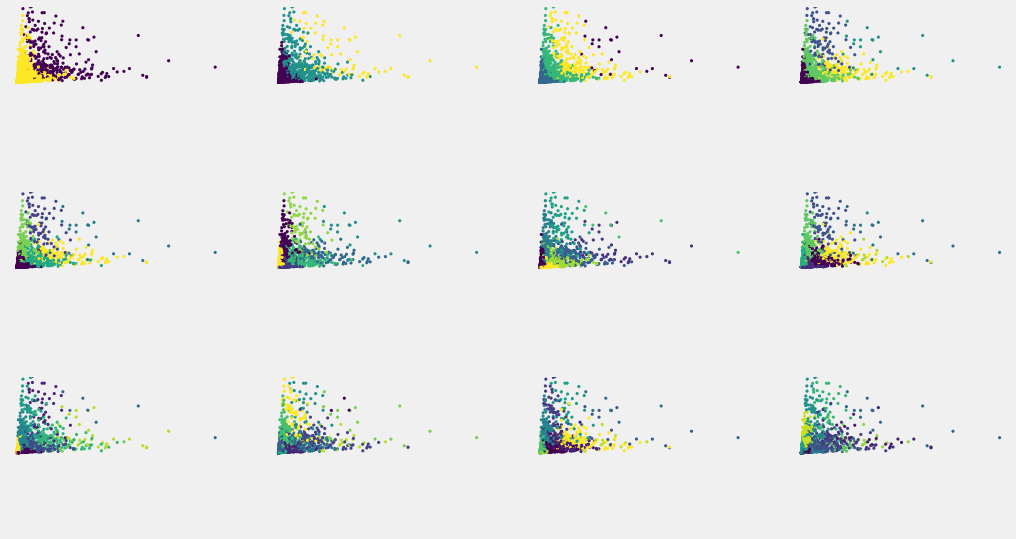

In [69]:
maxk = 14
wcss = np.zeros(maxk)
silhouette = np.zeros(maxk)

fig, axes = plt.subplots(3, 4, figsize=(16,9))

# flatten
axes = [ax for axrow in axes for ax in axrow]

for k, ax in zip(range(2,maxk), axes):
    km = KMeans(k)
    y = km.fit_predict(x)
    ax.axis('off')
    ax.scatter(x[:,0], x[:,1], c=y, linewidths=0, s=10)
    ax.set_ylim(ymin=-9, ymax=8)
    
    
    for c in range(0, k):
        for i1, i2 in itertools.combinations([ i for i in range(len(y)) if y[i] == c ], 2):
            wcss[k] += sum(x[i1] - x[i2])**2
    wcss[k] /= 2
    
    if k > 1:
        silhouette[k] = silhouette_score(x,y)

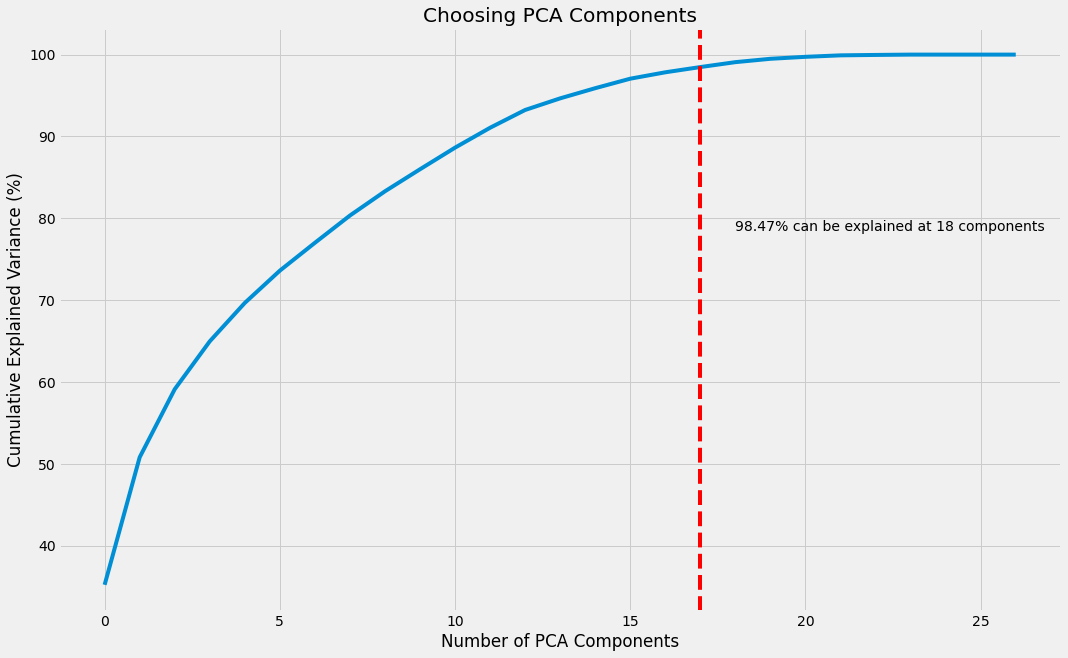

In [37]:
pca = PCA(x.shape[1])
pca.fit(x)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var_to_beat = np.argwhere(var1 >= 98)
var_explained = np.round(var1[var_to_beat[0]], decimals=2)[0]
comps = var_to_beat.flatten()[1]

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(var1)
ax.set_title('Choosing PCA Components')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Cumulative Explained Variance (%)')
ax.axvline(var_to_beat[0], c='r', linestyle='--')
ax.annotate(f'{var_explained}% can be explained at {comps} components', xy=(comps, var_explained-20))

plt.savefig('images/pca_scree_standard.png')

## Finding best cluster amounts

In [38]:
d_clusters = find_best_cluster_amount(x, comps, 250)
d_clusters = dict(sorted(d_clusters.items(), key=lambda item: item[1], reverse=True))
print(d_clusters)
print(f'Number of Clusters in order from best to worst: {d_clusters.keys()}')

{1: 71, 2: 52, 0: 35, 6: 17, 3: 12, 5: 9, 8: 9, 7: 8, 13: 8, 11: 8, 4: 6, 9: 5, 10: 5, 12: 5}
Number of Clusters in order from best to worst: dict_keys([1, 2, 0, 6, 3, 5, 8, 7, 13, 11, 4, 9, 10, 12])


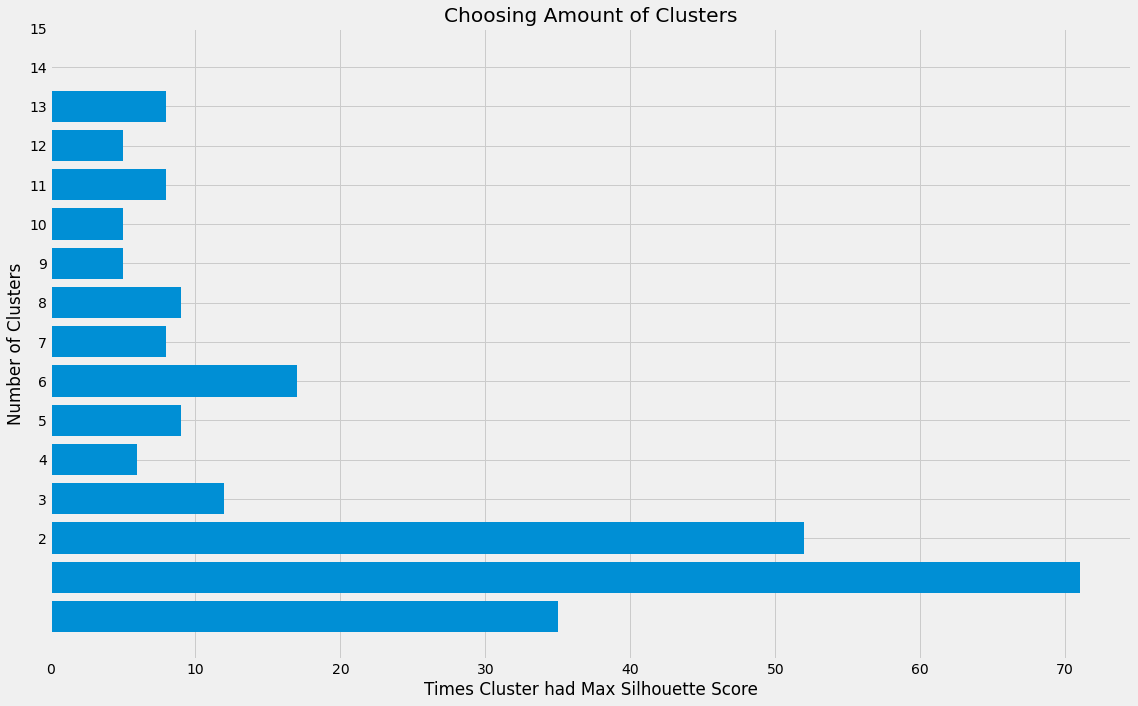

In [39]:
# Plotting Clusters
fig, ax = plt.subplots(figsize=(16,10))

ax.barh(list(d_clusters.keys()), list(d_clusters.values()))
ax.set_title('Choosing Amount of Clusters')
ax.set_xlabel('Times Cluster had Max Silhouette Score')
ax.set_ylabel('Number of Clusters')
ax.set_yticks(np.arange(2,16))

fig = ax.figure
fig.set_size_inches(16,10)
fig.tight_layout(pad=1)
fig.savefig('images/number_of_clusters_standard.png')

For n_clusters = 2 The average silhouette_score is : 0.3647980538751706


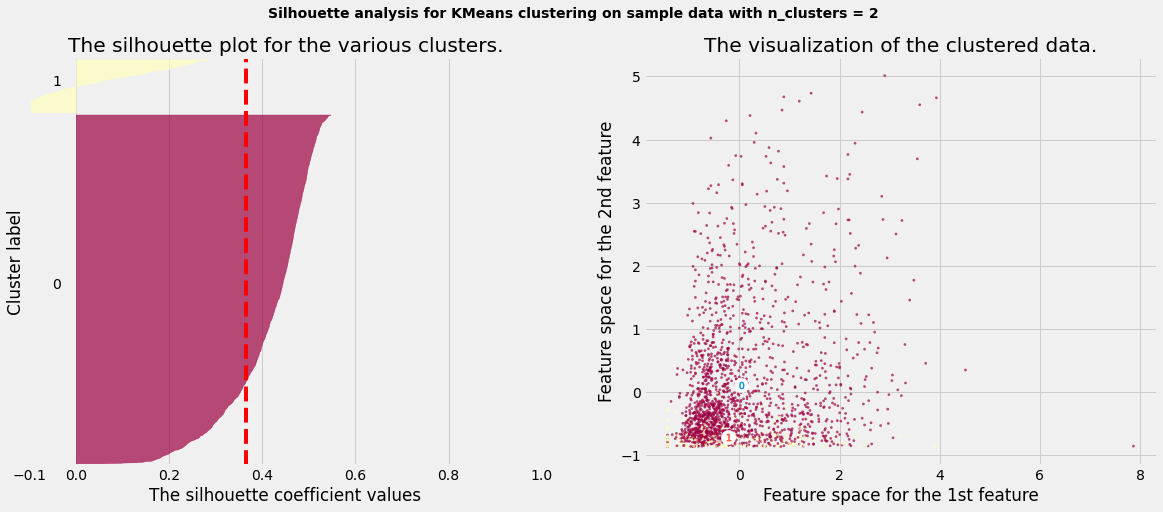

For n_clusters = 3 The average silhouette_score is : 0.20257691638431535


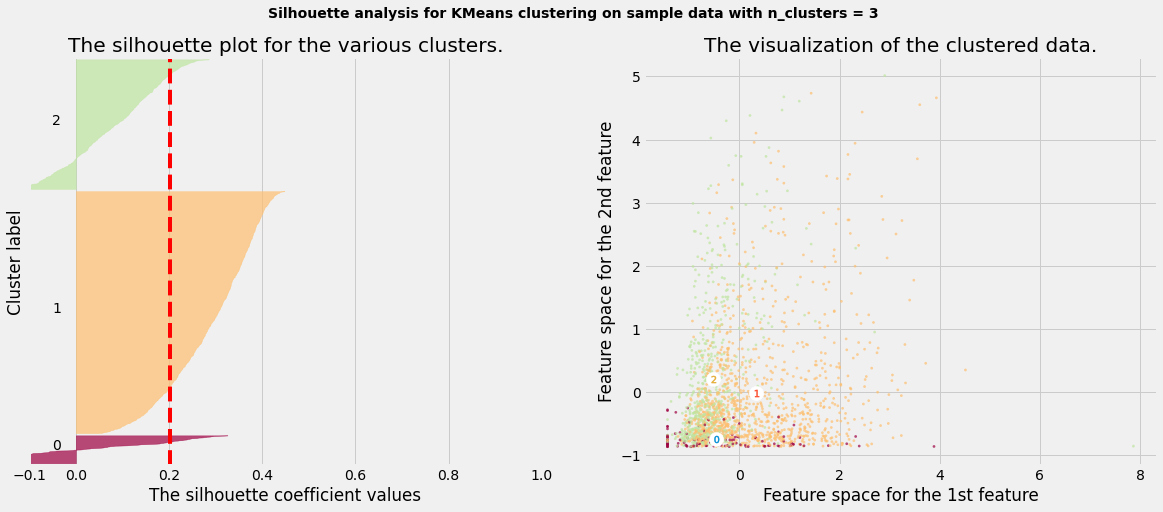

For n_clusters = 4 The average silhouette_score is : 0.16517767112090648


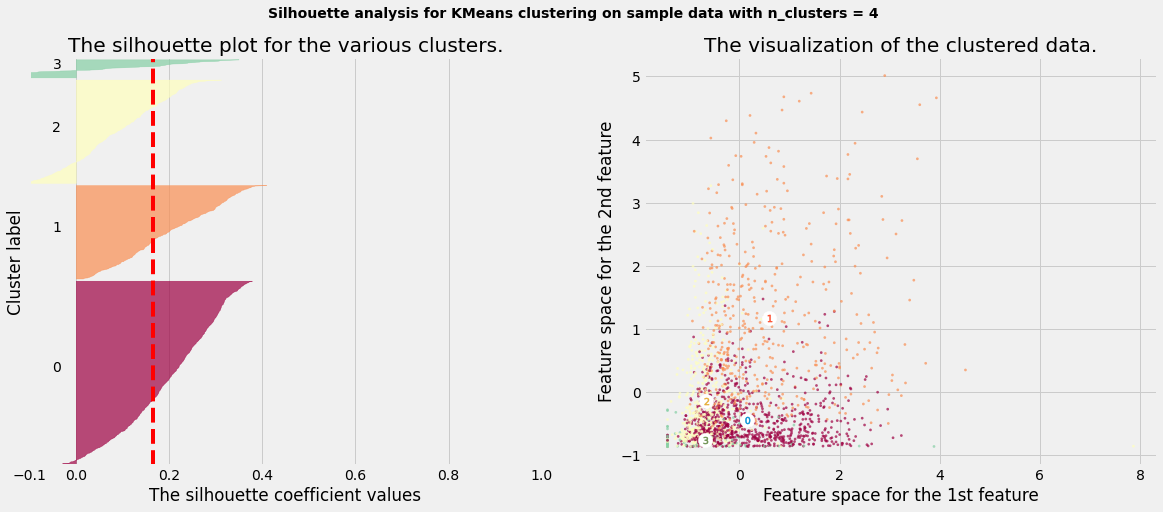

For n_clusters = 5 The average silhouette_score is : 0.16897224304843722


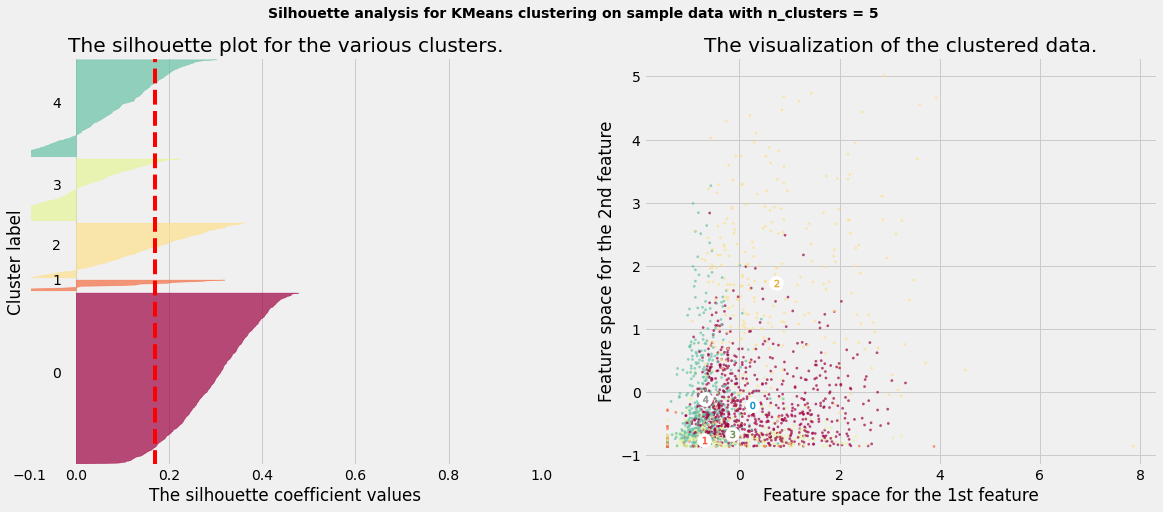

For n_clusters = 6 The average silhouette_score is : 0.1565754792971531


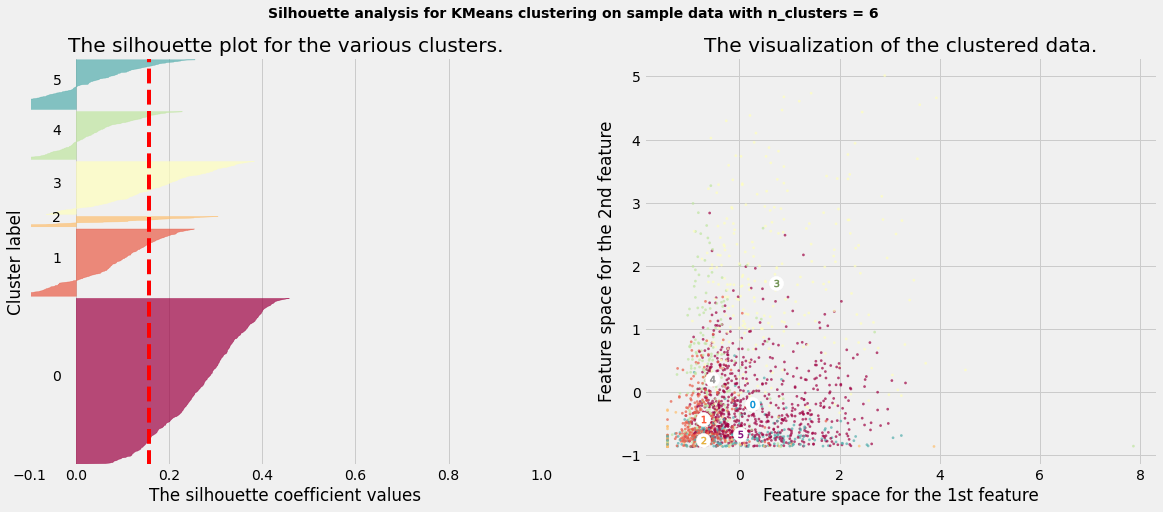

For n_clusters = 7 The average silhouette_score is : 0.15863839479064423


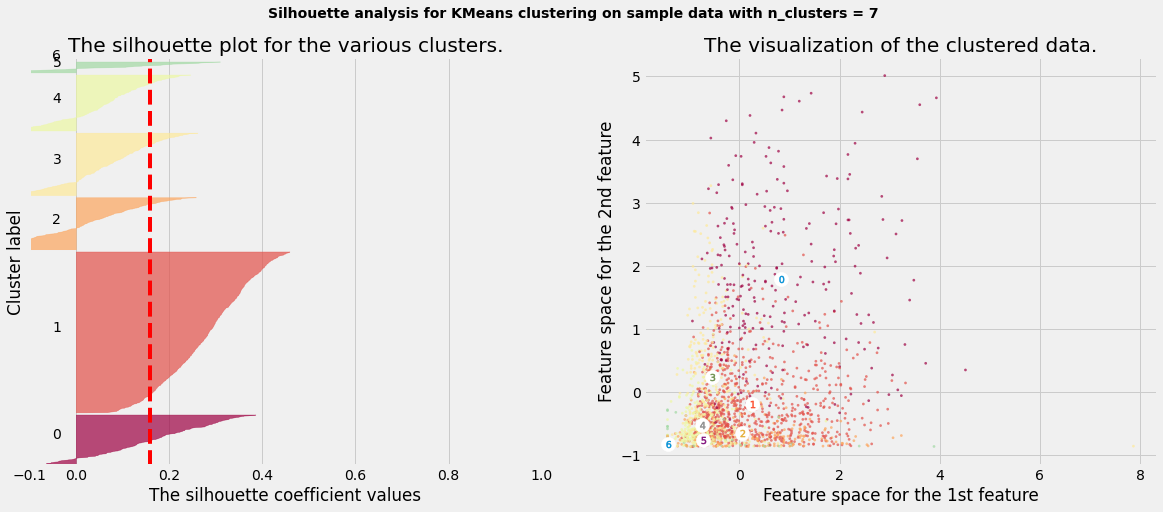

For n_clusters = 8 The average silhouette_score is : 0.09897073184396615


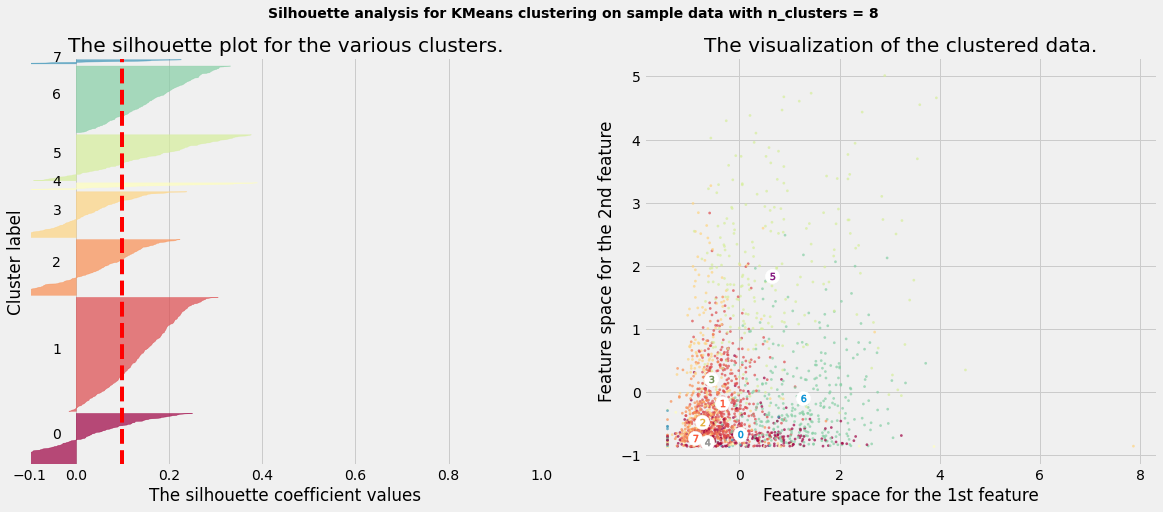

For n_clusters = 9 The average silhouette_score is : 0.10195399853598794


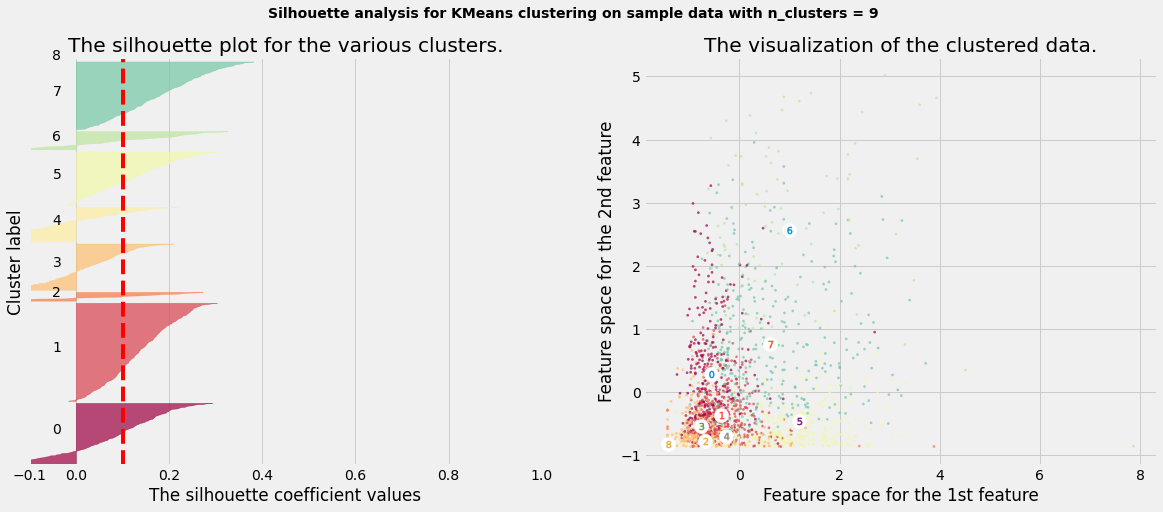

For n_clusters = 10 The average silhouette_score is : 0.0982400547915137


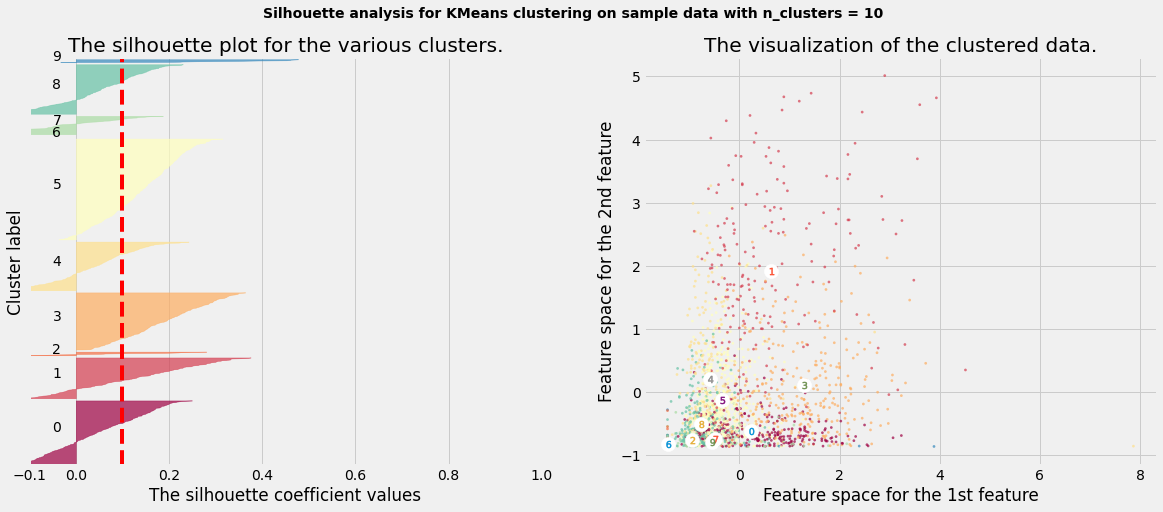

For n_clusters = 11 The average silhouette_score is : 0.103567120313557


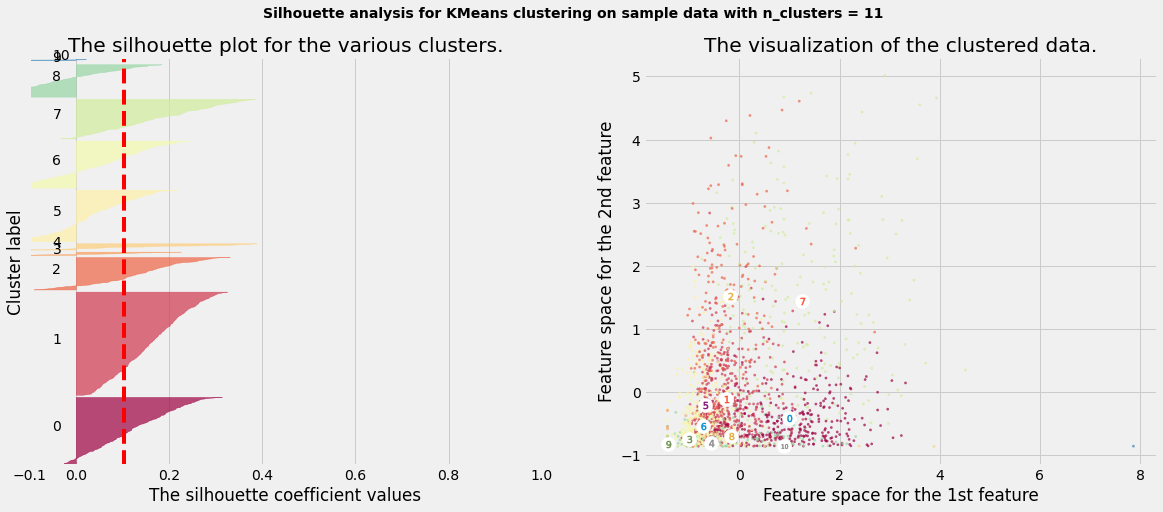

For n_clusters = 12 The average silhouette_score is : 0.10127504725112048


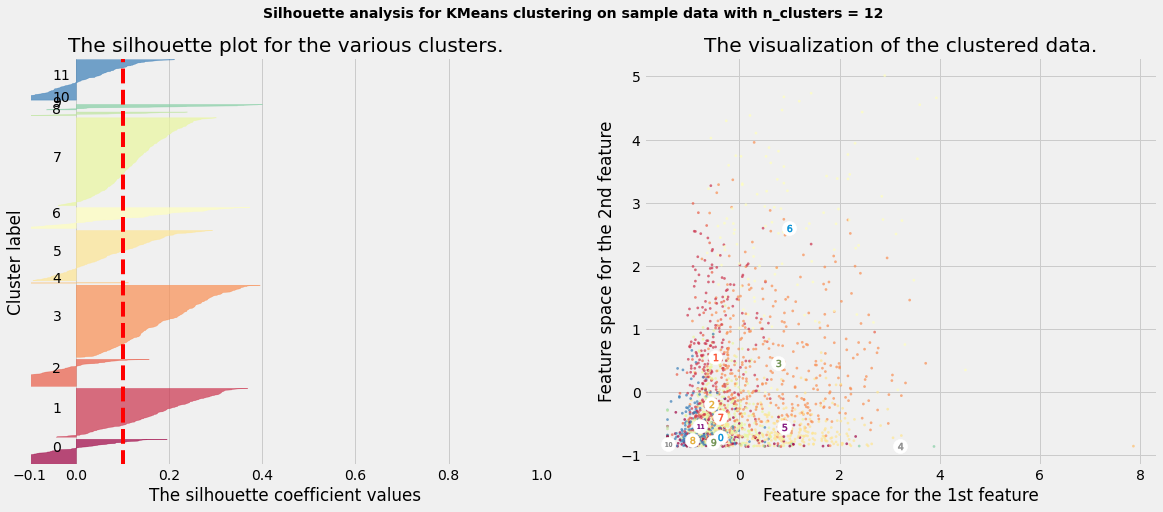

For n_clusters = 13 The average silhouette_score is : 0.0936030310719883


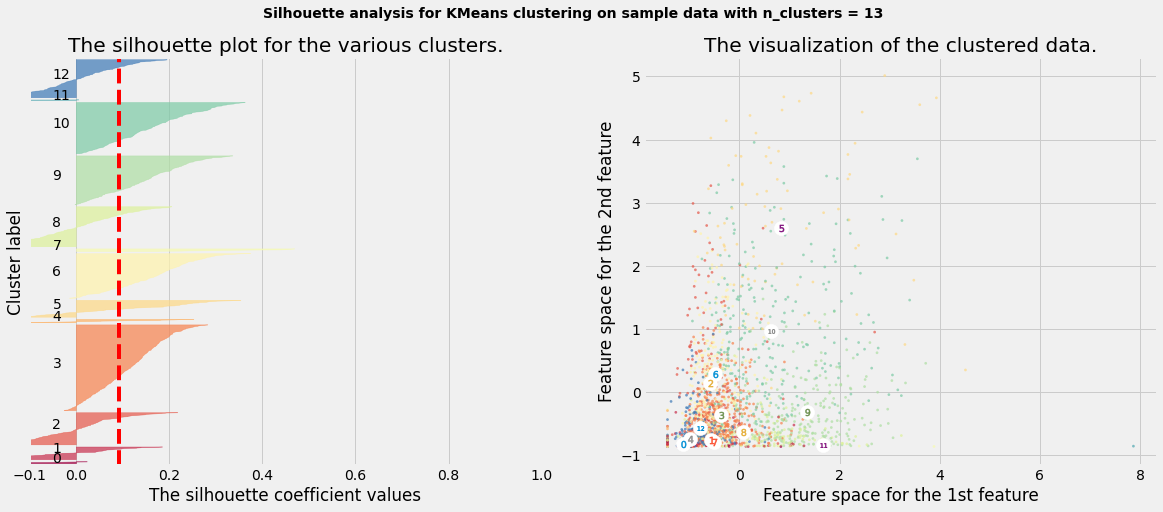

For n_clusters = 14 The average silhouette_score is : 0.08557218019717101


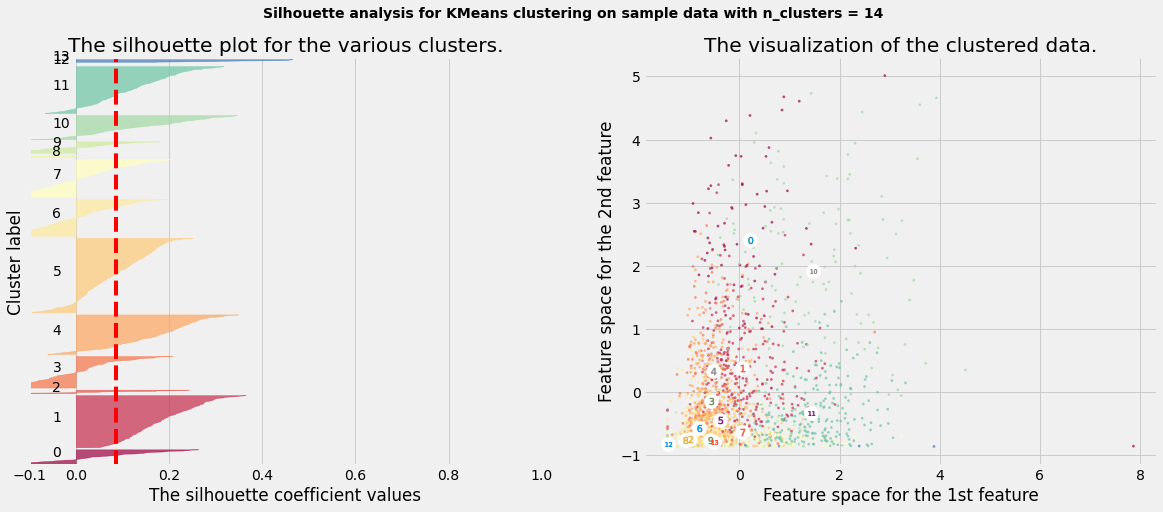

For n_clusters = 15 The average silhouette_score is : 0.08357521115898482


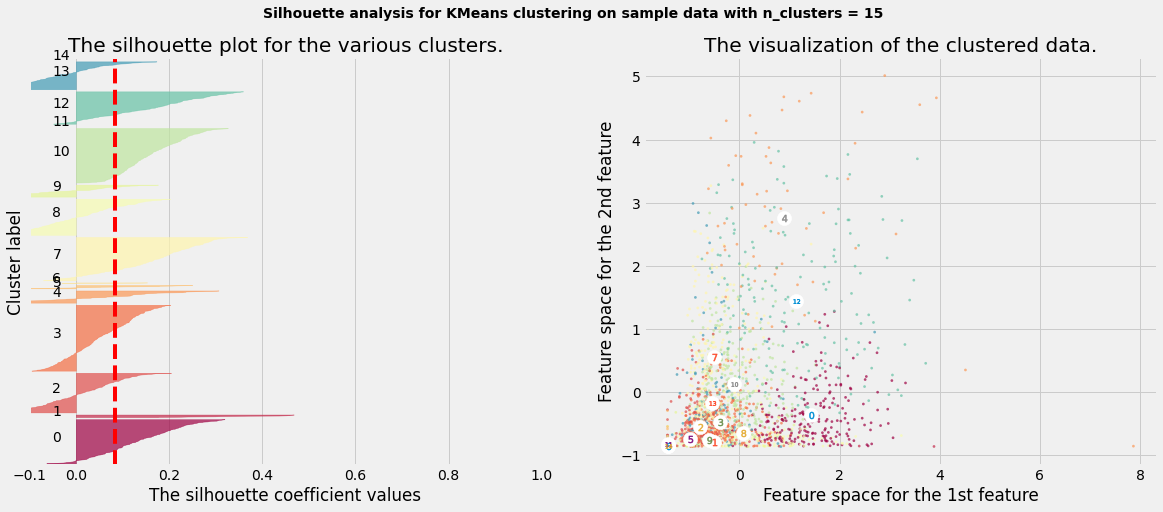

In [40]:
silhouette_graph(x, range(2,16))

## TSNE

In [41]:
# Trying TSNE
x_embedded = TSNE().fit_transform(x)
x_embedded.shape

(1923, 2)

perplexity=5 in 3.5 sec
perplexity=30 in 4.2 sec
perplexity=50 in 5 sec
perplexity=100 in 7 sec


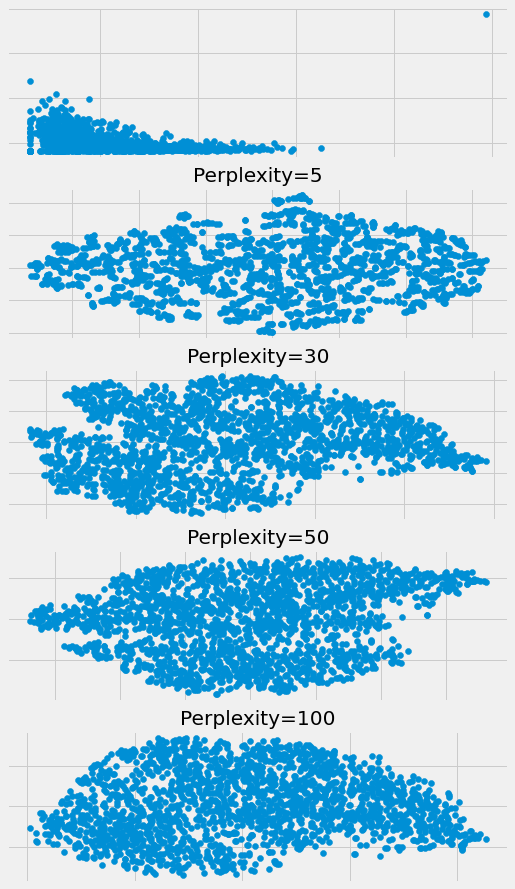

In [42]:
(fig, subplots) = plt.subplots(5, figsize=(8, 15))
n_components = 2
perplexities = [5, 30, 50, 100]

ax = subplots[0]
ax.scatter(x[:, 0], x[:, 2])
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(x)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')